# OpenSpace Asset for Ship Track


Alex Bock  Today at 4:33 AM
I think @Micah did something with a ships' trail a while ago. If I remember correctly, it was also using the trajectory file. Probably the best way is to look at the way the positions for the Apollo 11 landing sites are specified in here: https://github.com/OpenSpace/OpenSpace/blob/master/data/assets/scene/solarsystem/missions/apollo/11/lem_descent.asset It basically creates a TimelineTranslation which is indexed by time and the passed into a TrailTrajectory here: https://github.com/OpenSpace/OpenSpace/blob/master/data/assets/scene/solarsystem/missions/apollo/11/apollo11.asset#L133-L151
Checked and there is currently no way to perserve the time information in the GeoJSON. I did make an issue to track it though: https://github.com/OpenSpace/OpenSpace/issues/3701


In [6]:
import pandas as pd
from datetime import datetime as dt
df = pd.read_csv("RR2402_1min.geoCSV", comment = '#')
from datetime import datetime as dt
df['datetime'] = pd.to_datetime(df['iso_time'])
df.index = df['datetime']
df = df.resample("60min").first()
df = df.reset_index(drop=True)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'RR2402_1min.geoCSV'

In [8]:
def get_comment_dataframe(fname):
    """
    Reads a CSV file, extracts lines starting with '#', and returns them as a pandas DataFrame.

    Args:
        fname (str): The path to the CSV file.

    Returns:
        pandas.DataFrame: A DataFrame where the index represents the extracted
                          keys from comment lines (e.g., 'dataset', 'title'),
                          and the 'Value' column contains their corresponding values.
                          Returns an empty DataFrame if the file is not found or no
                          comment lines are present.
    """
    comment_data = {}
    try:
        with open(fname, 'r', encoding='utf-8') as f:
            for line in f:
                # Check if the line starts with '#' after stripping leading/trailing whitespace
                if line.strip().startswith('#'):
                    # Remove the '#' and any leading/trailing whitespace from the start of the line
                    processed_line = line.strip().lstrip('#').strip()
                    if ':' in processed_line:
                        # Split by the first colon to separate key and value
                        key, value = processed_line.split(':', 1)
                        comment_data[key.strip()] = value.strip()
                    else:
                        # If a line doesn't have a key:value format, store it with a generic key
                        # This handles cases like a standalone comment line without a colon
                        comment_data[f"unparsed_line_{len(comment_data)}"] = processed_line
    except FileNotFoundError:
        print(f"Error: The file '{fname}' was not found.")
        return pd.DataFrame(columns=['Value']) # Return an empty DataFrame on error
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return pd.DataFrame(columns=['Value']) # Return an empty DataFrame on error

    # Convert the dictionary to a pandas DataFrame
    # The dictionary keys become the DataFrame's index, and values go into the 'Value' column
    df_comments = pd.DataFrame.from_dict(comment_data, orient='index', columns=['Value'])
    return df_comments

# --- Example Usage ---
# Create a dummy CSV file for demonstration purposes
dummy_csv_content = """#dataset: GeoCSV 2.0
#title: Processed Trackline Navigation Data: One Minute Resolution
#field_unit: ISO_8601,degree_east,degree_north,meter/second,degree
#field_type: datetime,float,float,float,float
#ellipsoid: WGS-84 (EPSG:4326)
#this is a general comment
iso_time,ship_longitude,ship_latitude,speed_made_good,course_made_good
2024-10-15T00:00:00.00Z,-70.672198,41.524042,0.11,159.406
"""
dummy_filename = "data.csv"
with open(dummy_filename, "w", encoding="utf-8") as f:
    f.write(dummy_csv_content)

# Call the function with the dummy filename
comment_df = get_comment_dataframe(dummy_filename)

# Print the resulting DataFrame
print(comment_df)

# Example of handling a non-existent file
print("\n--- Testing with a non-existent file ---")
non_existent_df = get_comment_dataframe("tmp/RR1602_1min.geoCSV")
print(non_existent_df)

                                                             Value
dataset                                                 GeoCSV 2.0
title            Processed Trackline Navigation Data: One Minut...
field_unit       ISO_8601,degree_east,degree_north,meter/second...
field_type                        datetime,float,float,float,float
ellipsoid                                       WGS-84 (EPSG:4326)
unparsed_line_5                          this is a general comment

--- Testing with a non-existent file ---
                                                                 Value
dataset                                                     GeoCSV 2.0
title                Processed Trackline Navigation Data: One Minut...
field_unit           ISO_8601,degree_east,degree_north,meter/second...
field_type                            datetime,float,float,float,float
field_standard_name  iso_time,ship_longitude,ship_latitude,speed_ma...
field_long_name      date and time,longitude of vessel,latitude

In [12]:
non_existent_df.

AttributeError: 'DataFrame' object has no attribute 'cruise_id'

## Quick Approach: GeoJSON
Just want to see the track and don't need it animated? You can use the geocsv2geojson.py code in this folder to generate a GeoJSON file, then drag and drop that directly into OpenSpace. It'll look like this:
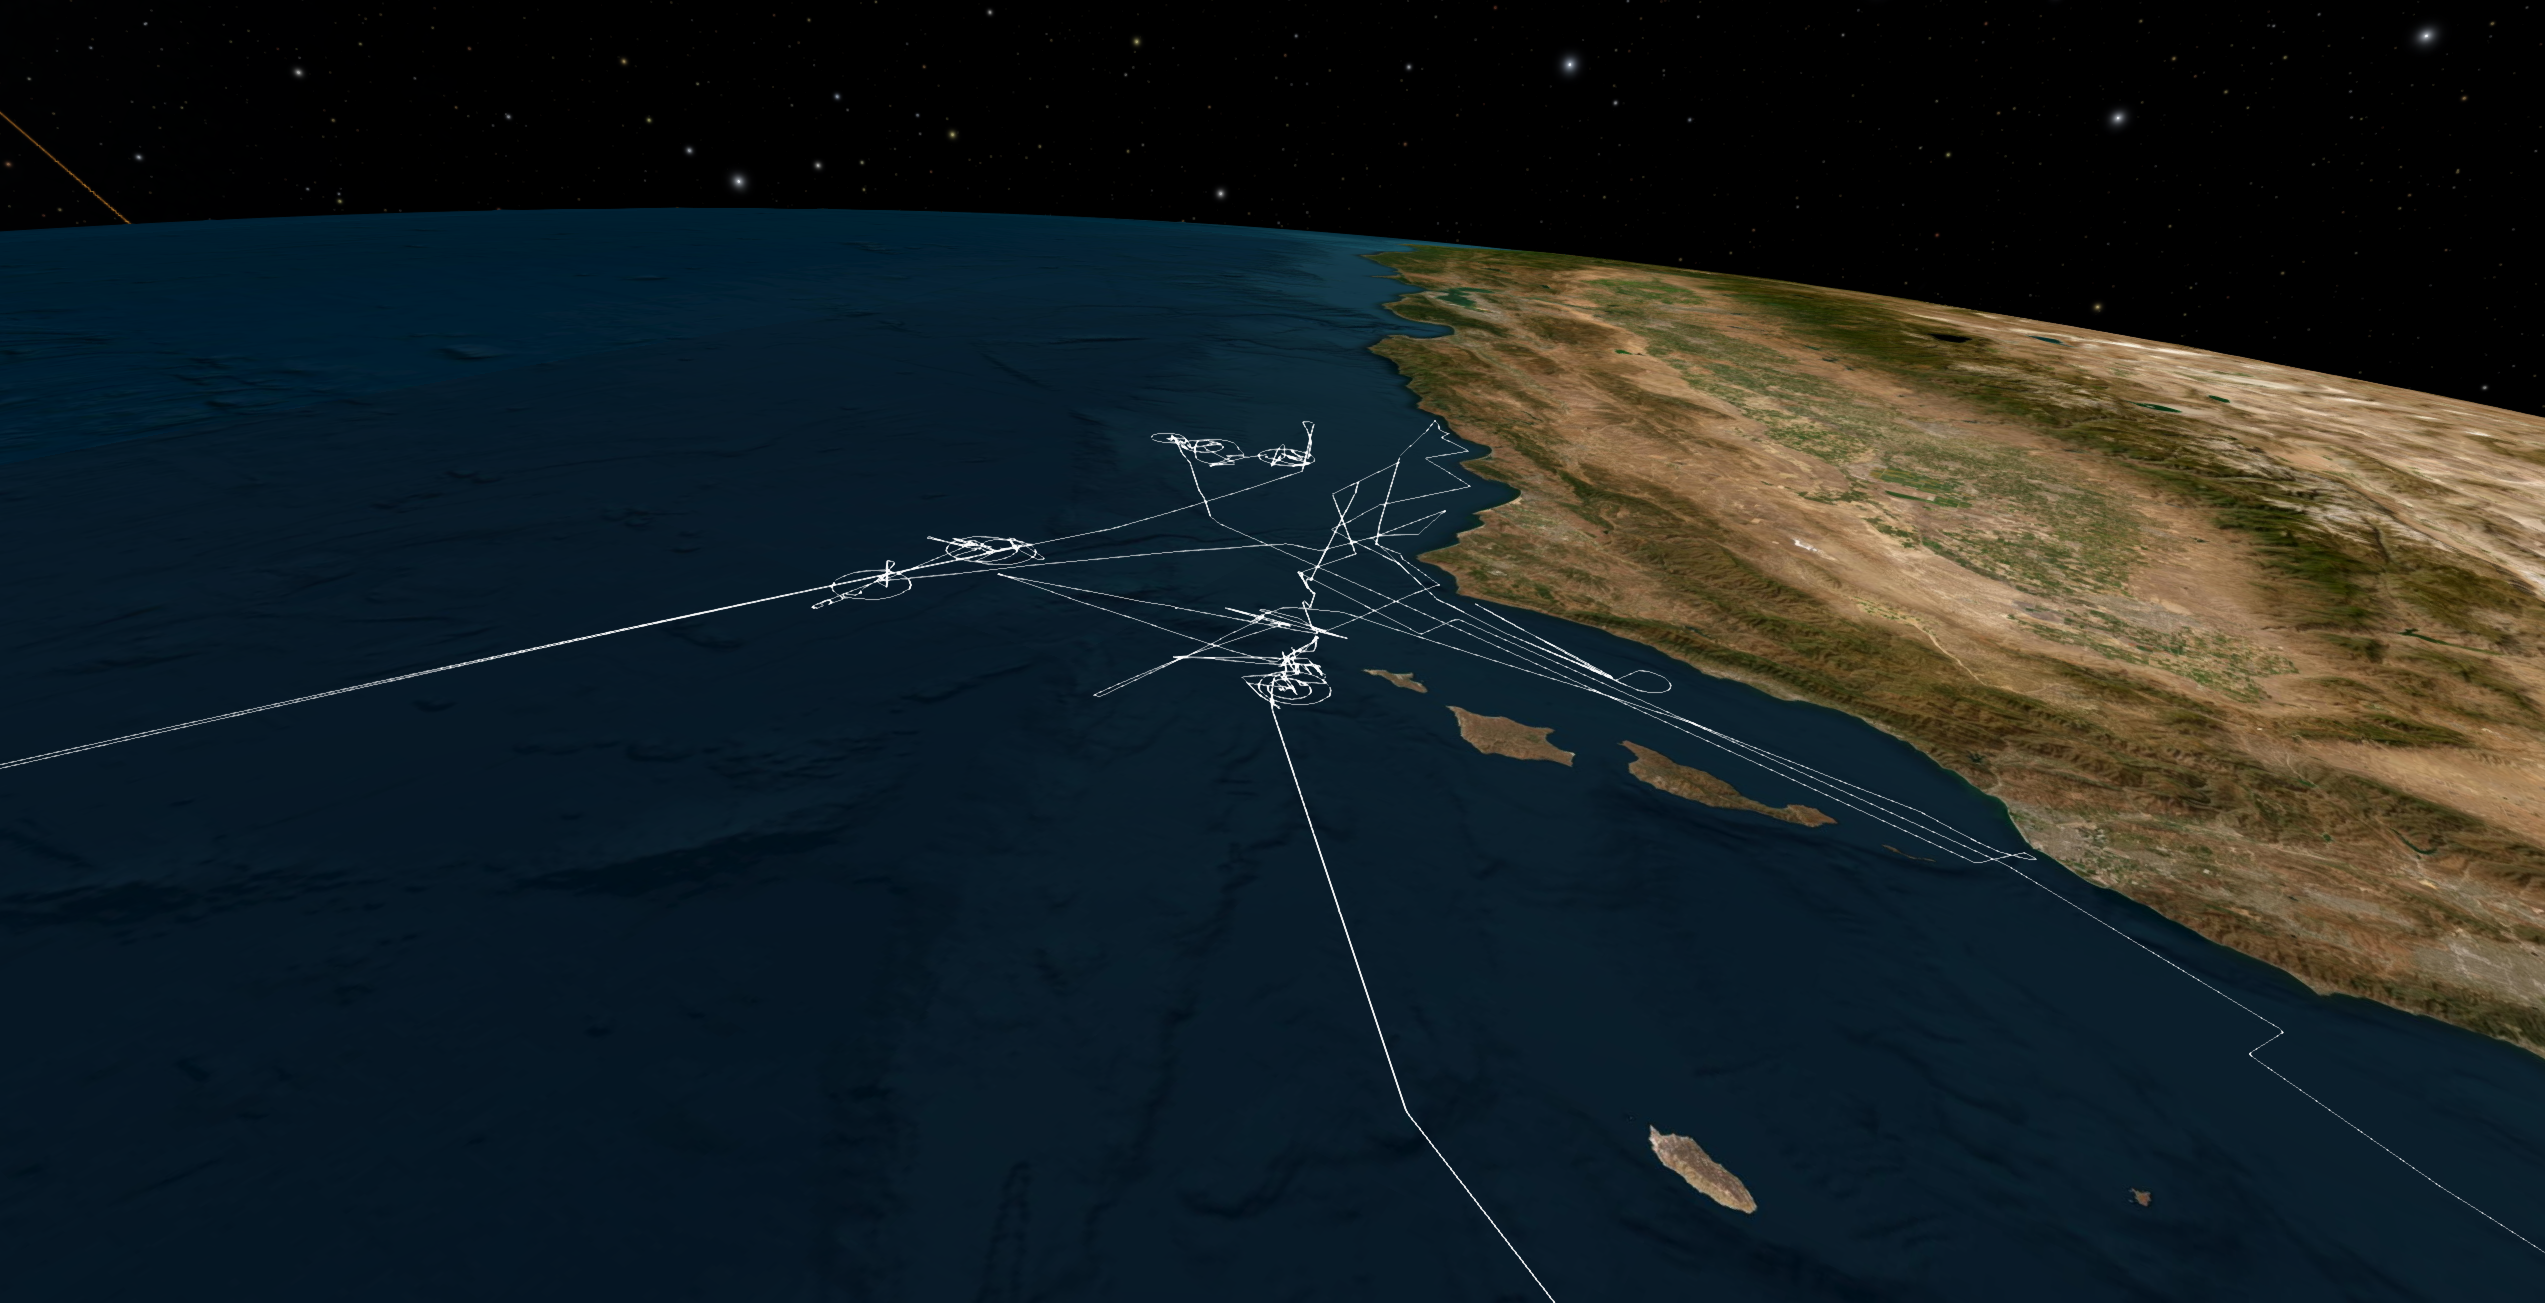

## Animated Version
What we really want, though, is an animated version of the asset that's more similar to a field line or satellite track. This will have two parts: 

### Step 1: Reformat geoCSV to TimelineTranslation
We want to format each line as a keyframe, like this:

```
  ["1969-07-20T20:13:40"] = {
    Type = "GlobeTranslation",
    Globe = "Moon",
    Longitude = 23.64480784327766,
    Latitude = 0.6899960896998255,
    Altitude = -1546.3568594681615,
    UseHeightmap = false
  },
```

For our version:

```
  ["2024-02-16T23:59:59"] = {
    Type = "GlobeTranslation",
    Globe = "Earth",
    Longitude = -117.236072,
    Latitude = 32.70652,
    Altitude = 0,
    SpeedMadeGood = 0.0,
    CourseMadeGood = 40.213,
    UseHeightmap = false
  },
```

TODO: Read the header of the original text file and incoporate it into the metadata of this file.


In [2]:
# # Function to format each row into the desired text block
# import itertools
# def format_row_to_text(row):
#     # Extract the timestamp, removing the ".00Z" part
#     iso_time_formatted = f'["{row["iso_time"].split(".")[0]}"]'

#     # Construct the formatted string
#     formatted_string = f"""  {iso_time_formatted} = {{
#     Type = "GlobeTranslation",
#     Globe = "Earth",
#     Longitude = {row["ship_longitude"]},
#     Latitude = {row["ship_latitude"]},
#     Altitude = 0,
#     SpeedMadeGood = {row["speed_made_good"]},
#     CourseMadeGood = {row["course_made_good"]},
#     UseHeightmap = false
#   }},"""
#     return formatted_string

# # Apply the function to each row of the DataFrame and print the results
# # for index, row in df.iterrows():
# for index, row in itertools.islice(df.iterrows(), 1):
#     print(format_row_to_text(row))

In [3]:
import io

# Function to format each row into the desired text block
def format_row_to_text(row):
    # Extract the timestamp, removing the ".00Z" part
    iso_time_formatted = f'["{row["iso_time"].split(".")[0]}"]'

    # Construct the formatted string
    formatted_string = f"""  {iso_time_formatted} = {{
    Type = "GlobeTranslation",
    Globe = "Earth",
    Longitude = {row["ship_longitude"]},
    Latitude = {row["ship_latitude"]},
    Altitude = 0,
    SpeedMadeGood = {row["speed_made_good"]},
    CourseMadeGood = {row["course_made_good"]},
    UseHeightmap = false
  }}"""
    return formatted_string

# Define the "before" and "after" text
# TODO: copy original CSV header in here, as commented Lua text.
before_text = """local keyframes = {
"""

after_text = """}

asset.export("keyframes", keyframes)

asset.meta = {
  Name = "Ship Track Position",
  Description = [[This asset provides position information for the ship track.]],
  Author = "OpenSpace Team",
  URL = "http://doi.org/10.7284/910464",
  License = "MIT license"
}
"""

# Specify the output file name
# TODO: Pull this from metadata
output_filename = "RR2402_keyframes.asset"

# Open the file in write mode and write the content
with open(output_filename, "w") as f:
    f.write(before_text) # Write the "before" text first

    # Iterate through each row of the DataFrame, format it, and write to the file
    for index, row in df.iterrows():
        if index<len(df):
            f.write(format_row_to_text(row) + ",\n") # Add a newline after each entry for readability
        else:
            f.write(format_row_to_text(row) + "\n") #skip comma on last entry
    f.write(after_text) # Write the "after" text

print(f"Successfully generated '{output_filename}' with the formatted data.")

Successfully generated 'RR2402_keyframes.asset' with the formatted data.


In [5]:
fname = "tmp/RR1602_1min.geoCSV"


df = pd.read_csv(fname, comment = '#')
from datetime import datetime as dt
df['datetime'] = pd.to_datetime(df['iso_time'])
df.index = df['datetime']
df = df.resample("60min").first()
df = df.reset_index(drop=True)
df.head()

,iso_time,ship_longitude,ship_latitude,speed_made_good,course_made_good,datetime
0,2016-01-30T07:22:03Z,112.682130,-18.491275,0.00,183.151,2016-01-30 07:22:03+00:00
1,2016-01-30T08:00:00Z,112.682415,-18.609538,5.54,177.978,2016-01-30 08:00:00+00:00
2,2016-01-30T09:00:00Z,112.682545,-18.797845,5.87,180.000,2016-01-30 09:00:00+00:00
3,2016-01-30T10:00:00Z,112.682653,-18.982837,5.76,180.000,2016-01-30 10:00:00+00:00
4,2016-01-30T11:00:00Z,112.682787,-19.168528,5.31,178.992,2016-01-30 11:00:00+00:00


In [ ]:
import io


# Function to format each row into the desired text block
def format_row_to_text(row):
    # Extract the timestamp, removing the ".00Z" part
    iso_time_formatted = f'["{row["iso_time"].split(".")[0]}"]'

    # Construct the formatted string
    formatted_string = f"""  {iso_time_formatted} = {{
    Type = "GlobeTranslation",
    Globe = "Earth",
    Longitude = {row["ship_longitude"]},
    Latitude = {row["ship_latitude"]},
    Altitude = 0,
    SpeedMadeGood = {row["speed_made_good"]},
    CourseMadeGood = {row["course_made_good"]},
    UseHeightmap = false
  }}"""
    return formatted_string

def get_cruise_asset(fname, resample_rate="60min"):

    df = pd.read_csv(fname, comment = '#')
    df['datetime'] = pd.to_datetime(df['iso_time'])
    df.index = df['datetime']
    df = df.resample(resample_rate).first()
    df = df.reset_index(drop=True)
    print(df.head(3))
    # Define the "before" and "after" text
    # TODO: copy original CSV header in here, as commented Lua text.
    before_text = """local keyframes = {
    """
    
    after_text = """}
    
    asset.export("keyframes", keyframes)
    
    asset.meta = {
      Name = "Ship Track Position",
      Description = [[This asset provides position information for the ship track.]],
      Author = "OpenSpace Team",
      URL = "http://doi.org/10.7284/910464",
      License = "MIT license"
    }
    """
    
    # Specify the output file name
    # TODO: Pull this from metadata
    output_filename = cruise_id+"_keyframes.asset"
    
    # Open the file in write mode and write the content
    with open(output_filename, "w") as f:
        f.write(before_text) # Write the "before" text first
    
        # Iterate through each row of the DataFrame, format it, and write to the file
        for index, row in df.iterrows():
            if index<len(df):
                f.write(format_row_to_text(row) + ",\n") # Add a newline after each entry for readability
            else:
                f.write(format_row_to_text(row) + "\n") #skip comma on last entry
        f.write(after_text) # Write the "after" text
    
    print(f"Successfully generated '{output_filename}' with the formatted data.")

### Step 2: 
Our basis for this part is 
https://github.com/OpenSpace/OpenSpace/blob/master/data/assets/scene/solarsystem/missions/apollo/11/apollo11.asset#L133-L151 

Adapted for our purposes:

```
local ShipTrack = {
  Identifier = "Apollo11LemTrail",
  Parent = moonTransforms.Moon.Identifier,
  Renderable = {
    Type = "RenderableTrailTrajectory",
    Enabled = false,
    Translation = lemTranslation,
    Color = { 0.780000,0.940000,0.340000 },
    StartTime = "1969 JUL 20 19:10:25.183",
    EndTime = "1969 JUL 20 20:17:46.183",
    SampleInterval = 2,
    EnableFade = false
  },
  GUI = {
    Name = "Apollo 11 Lunar Lander Trail",
    Path = "/Ship Tracks",
    Focusable = false
  }
}
```

We want a 3D model of the ship in question. If one is not available, might I suggest https://github.com/CreativeTools/3DBenchy/blob/master/Single-part/3DBenchy.stl ?
Or perhaps https://github.com/DASSL/dassl-duck/blob/master/dasslDuck.obj ?